# HISEAS Last Interglacial (LIG) Sea-Surface Temperature (SST) Visualization: Reduced Space Optimal Interpolation

#### Author: Anna Chen (yc4406@columbia.edu)
#### Created on Sep 7, 2025
#### Updated on Jan 30, 2026
Based on "SST_EOF_V2" notebook from summer research and the methodology handbook updated on Nov 19, 2025

## 0. Overview

The HISEAS Project is an international paleo-climate research collaboration that aims to answer: “**How much and why did Ice Sheets melt during the Last Interglacial?**” (HISEAS).

My role in this project, thus far, has been focusing on quantitatively understanding the spatial and temporal patterns of Sea-Surface Temperature (SST) during the Last Interglacial (LIG, $\approx$ 130-115 ka). 
This is done by reconstructing full-field SST maps across 130.0-115.0 ka at every 0.1 ka time-steps using the LIG SST dataset complied by Hoffman et al. (2017).

**Works Cited**

Evans, M. N., Kaplan, A., & Cane, M. A. (2002). Pacific sea surface temperature field reconstruction from coral δ18O data using reduced space objective analysis. Paleoceanography, 17(1), 7-1-7–13. https://doi.org/10.1029/2000PA000590

Hoffman, J. S., Clark, P. U., Parnell, A. C., & He, F. (2017). Regional and global sea-surface temperatures during the last interglaciation. Science, 355(6322), 276–279. https://doi.org/10.1126/science.aai8464

Kaplan, A., Kushnir, Y., Cane, M. A., & Blumenthal, M. B. (1997). Reduced space optimal analysis for historical data sets: 136 years of Atlantic sea surface temperatures. Journal of Geophysical Research: Oceans, 102(C13), 27835–27860. https://doi.org/10.1029/97JC01734

Rayner, N. A., Parker, D. E., Horton, E. B., Folland, C. K., Alexander, L. V., Rowell, D. P., et al. (2003). Global analyses of sea surface temperature, sea ice, and night marine air temperature since the late nineteenth century. Journal of Geophysical Research: Atmospheres, 108(D14). https://doi.org/10.1029/2002JD002670

## 1. Decompose modern data (HadISST) through Empirical Orthogonal Function (EOF) analysis

In [12]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pathlib import Path

import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="openpyxl.worksheet._read_only",
    message="Unknown extension is not supported and will be removed"
)

In [13]:
# ---------------------------------------------------------------------
# Configuration / inputs
# ---------------------------------------------------------------------
# excel_file = "SST_Hoffman_Harmonized_AC_ES_no_V28_238.xlsx"     # One core removed due to inconsistency in temporal availability

excel_file = "SST_Hoffman_Harmonized_AC_ES.xlsx"                  # Now use all cores
hadisst_nc = "HadISST_sst.nc"

# Sheets to skip (non-SST metadata sheets)
non_sst = [
    "Reference Cores Tie Points",
    "Fig1 Global & Regional Stacks",
    "HadSST & SynTrACE Bias Estimate",
    "TEMPLATE",
    "NATL Data Read Me",
    "PAC Data Read Me",
    "IND Data Read Me",
    "SATL Data Read Me",
]

# Summer-core list (apply August anomaly correction to these only)
summer_core_ids = [
    "M23323-1_UK37", "EW9302-JPC8", "ODP 980", "NA87-25", "NEAP18k",
    "MD04-2845", "SU92-03", "CH69-K09", "MD95-2040_Foram", "SU90-03",
    "MD95-2036", "KNR140-37JPC", "ODP 1089_Radiolaria", "MD94-101",
    "PS2489-2", "MD84-527", "MD94-102", "MD88-770_Diatom", "MD02-2488"
]

# Target ages for map plots (Kya)
key_ages = [130.0, 127.0, 125.0, 120.0, 115.0]

# ---------------------------------------------------------------------
# Utility helpers
# ---------------------------------------------------------------------

def nearest_index_age(age_array, target_age):
    """Return column index closest to 'target_age'."""
    return int(np.nanargmin(np.abs(age_array - target_age)))

def plot_mode_fields(E_mode_flat, pc_series, nlat, nlon, lats, lons, mode_idx):
    """Spatial + temporal plot for one mode."""
    full = E_mode_flat.reshape(nlat, nlon)
    vmax = np.nanmax(np.abs(full))
    plt.figure(figsize=(7.5, 3.2))
    plt.imshow(full, origin='lower', extent=[-180,180,-90,90],
               vmin=-vmax, vmax=vmax, cmap="coolwarm", aspect='auto')
    plt.title(f"Weighted EOF {mode_idx+1}")
    plt.colorbar(label="loading")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(7.5, 3.2))
    plt.plot(pc_series, lw=1)
    plt.title(f"EOF {mode_idx+1} Principal Component")
    plt.xlabel("Season-year index (1870→2020)")
    plt.grid(ls=":")
    plt.tight_layout(); plt.show()

# =====================================================================
# STEP 1–9 : Modern data (centralize → weight → SVD → Λ → x′_Aug)
# =====================================================================

# STEP 1: Load HadISST seasons (April→March)
ds = xr.open_dataset(hadisst_nc).where(lambda d: d.sst > -10)
ds = ds.sel(time=slice("1870-04-01", "2021-03-31"))  # 1812 months
months = ds.time.dt.month.values
years  = ds.time.dt.year.values
season_id = np.where(months >= 4, years, years - 1)
ds = ds.assign_coords(season_year=("time", season_id))

HadISST_annual = ds.sst.groupby("season_year").mean("time", skipna=True).sortby("latitude")
HadISST_aug    = ds.sst.where(ds.time.dt.month == 8).groupby("season_year").mean("time", skipna=True)
HadISST_aug    = HadISST_aug.reindex(season_year=HadISST_annual.season_year).sortby("latitude")

T = HadISST_annual.shape[0]        # should be 151
nlat, nlon = HadISST_annual.shape[1:]
N_full = nlat * nlon

# Flatten (N_full, T)
X_full     = HadISST_annual.values.reshape(T, N_full).T
X_aug_full = HadISST_aug.values.reshape(T, N_full).T

# STEP 2: Ocean mask (drop any row with NaN over time)
valid_mask    = ~np.any(np.isnan(X_full), axis=1)
valid_indices = np.where(valid_mask)[0]
X             = X_full[valid_mask, :]      # (N, T) ocean-only
X_aug         = X_aug_full[valid_mask, :]
N = X.shape[0]

# STEP 3: August–annual anomaly time-mean (physical space)
A = X_aug - X                      # (N, T)
x_Aug = np.nanmean(A, axis=1)      # (N,)

# STEP 2 (from doc): Row mean (physical space)
x = np.mean(X, axis=1, keepdims=True)      # (N,1)

# STEP 3: Centralize (physical) BEFORE weighting
X_c = X - x                               # (N, T)

# STEP 4: Area weights (normalized cos φ)
# Build latitude array matching the flattened order:
lats = HadISST_annual.latitude.values     # (nlat,)
lons = HadISST_annual.longitude.values    # (nlon,)
lat_grid = np.repeat(lats[:, None], nlon, axis=1).reshape(-1)  # (N_full,)
w_full = np.cos(np.deg2rad(lat_grid))
w_full = w_full / np.nansum(w_full)
w = w_full[valid_mask]                    # (N,)
sqrtw = np.sqrt(w)                        # (N,)

# STEP 5: Weighted data (X′ = W^{1/2} X_c)
X_prime = sqrtw[:, None] * X_c            # (N, T)

# STEP 6: Weighted SVD  X′ = E′ Σ Vᵀ  with (E′)ᵀE′ = I
U, s, Vt = np.linalg.svd(X_prime, full_matrices=False)
Eprime = U          # (N, T)
V = Vt.T            # (T, T)

# STEP 7: Truncate r=20
r = 20
E = Eprime[:, :r]                         # (N, r) area-weighted EOFs
s_r = s[:r]                               # (r,)
V_r = V[:, :r]                            # (T, r)

# STEP 8: Unbiased prior Λ = Σ² / (T-1)
Λ = np.diag((s_r ** 2) / (T - 1))         # (r, r)

# Apply graphing sign flip to make leading EOF mostly non-negative
D = -np.eye(r)          # per §2 item 4, use D = -I
E = E @ D               # flip all EOF columns
V_r = V_r @ D           # flip all PC columns

# STEP 9: Weighted August anomaly vector
x_Aug_prime = sqrtw * x_Aug               # (N,)
x_prime     = sqrtw * x[:, 0]             # (N,)  (weighted mean of X)

## 2. Reconstruct Last-Interglacial (paleo) full-field SST using Reduced-Space Optimal Interpolation (RSOI)

In [14]:
# =====================================================================
# STEP 10–12 : Paleo core metadata & time series
# =====================================================================

# STEP 10: Build df_LIG with rounded coordinates (−180..180, −90..90)
records = []
xls = pd.ExcelFile(excel_file)
for sheet in xls.sheet_names:
    if sheet in non_sst:
        continue
    meta = pd.read_excel(xls, sheet_name=sheet, header=None, usecols="A:C", nrows=2)
    records.append({"ID": sheet, "origin_lon": meta.iloc[1,1], "origin_lat": meta.iloc[1,2]})

df_LIG = pd.DataFrame(records)
df_LIG["round_lon"] = (np.floor(df_LIG.origin_lon) + 0.5).clip(-179.5, 179.5)
df_LIG["round_lat"] = (np.floor(df_LIG.origin_lat) + 0.5).clip(-89.5, 89.5)

# Map each core to the condensed-grid row index
row_lookup = {}
for i, r_ in df_LIG.iterrows():
    lat_idx = np.where(np.isclose(lats, r_["round_lat"]))[0]
    lon_idx = np.where(np.isclose(lons, r_["round_lon"]))[0]
    if len(lat_idx)==0 or len(lon_idx)==0:
        continue
    full_idx = lat_idx[0] * nlon + lon_idx[0]
    # Convert full index → ocean-only row
    match = np.where(valid_indices == full_idx)[0]
    if match.size == 0:
        continue
    row_lookup[i] = int(match[0])

# STEP 11: Read paleo SST (column T) per sheet, 151 rows (115→130 ascending)
n_cores = len(df_LIG)
Y = np.full((n_cores, 151), np.nan)
Y_plus2 = np.full_like(Y, np.nan)  # column U (SST+2σ)

for i, cid in enumerate(df_LIG.ID):
    ts_T = pd.read_excel(excel_file, sheet_name=cid, usecols="T", skiprows=1, header=None, nrows=151)
    ts_U = pd.read_excel(excel_file, sheet_name=cid, usecols="U", skiprows=1, header=None, nrows=151)
    Y[i, :len(ts_T)] = pd.to_numeric(ts_T.iloc[:,0], errors="coerce").values
    Y_plus2[i, :len(ts_U)] = pd.to_numeric(ts_U.iloc[:,0], errors="coerce").values

# Ages (Kya) as stored (ascending: 115 → 130)
ages_asc = np.linspace(115.0, 130.0, 151)

# STEP 12: Multi-proxy per cell/time via Optimal Estimation
# STEP 12: Multi-proxy per cell/time via Optimal Estimation (robust to σ=0; no summer correction)

# Group cores by rounded 1°×1° cell → "sites"
df_LIG["group_key"] = list(zip(df_LIG.round_lon.values, df_LIG.round_lat.values))
groups = df_LIG.groupby("group_key", sort=False)

site_records = []
Y_sites, Sigma_sites = [], []

for (rlon, rlat), g in groups:
    idxs = g.index.to_numpy()

    # contributors (rows in the current df_LIG / Y / Y_plus2)
    vals   = Y[idxs, :]                                # (#cores_in_site, 151)
    sigmas = (Y_plus2[idxs, :] - Y[idxs, :]) / 2.0     # (#cores_in_site, 151)

    # Initialize site-level outputs
    Y_hat     = np.full(151, np.nan, dtype=float)
    sigma_hat = np.full(151, np.nan, dtype=float)

    # Robust OE per time (column-wise)
    for tcol in range(151):
        col_vals = vals[:, tcol]
        col_sig  = sigmas[:, tcol]

        # σ=0 contributors (with finite value) → average them; σ̂ = 0
        exact_mask = (col_sig == 0) & np.isfinite(col_vals)
        if np.any(exact_mask):
            Y_hat[tcol]     = np.nanmean(col_vals[exact_mask])
            sigma_hat[tcol] = 0.0
            continue

        # Standard inverse-variance weighting
        with np.errstate(divide='ignore', invalid='ignore'):
            invvar = 1.0 / (col_sig**2)

        # Drop non-finite weights and missing values
        invvar[~np.isfinite(invvar)] = np.nan
        invvar[np.isnan(col_vals)]   = np.nan

        wsum = np.nansum(invvar)
        if np.isfinite(wsum) and (wsum > 0):
            weights = invvar / wsum
            Y_hat[tcol]     = np.nansum(weights * col_vals)
            sigma_hat[tcol] = np.sqrt(1.0 / wsum)
        # else: leave NaNs (no valid contributors at this time)

    Y_sites.append(Y_hat)
    Sigma_sites.append(sigma_hat)

    # representative ID = always the FIRST ID for this site
    rep_id = g["ID"].iloc[0]

    # keep origin lon/lat from the first contributor (informational)
    site_records.append({
        "ID": rep_id,
        "origin_lon": g.iloc[0]["origin_lon"],
        "origin_lat": g.iloc[0]["origin_lat"],
        "round_lon": rlon,
        "round_lat": rlat
    })

# Overwrite df_LIG with site-level table
df_LIG = pd.DataFrame(site_records).reset_index(drop=True)

# Overwrite Y and Y_plus2 with site-level arrays so downstream code is unchanged
Y        = np.vstack(Y_sites)                 # (n_sites, 151)
Sigma    = np.vstack(Sigma_sites)             # (n_sites, 151)
Y_plus2  = Y + 2.0 * Sigma

# Update n_cores to reflect number of sites
n_cores = len(df_LIG)

# Rebuild row_lookup for the site table (mapping site index → ocean-only grid row)
row_lookup = {}
for i, r_ in df_LIG.iterrows():
    lat_idx = np.where(np.isclose(lats, r_["round_lat"]))[0]
    lon_idx = np.where(np.isclose(lons, r_["round_lon"]))[0]
    if len(lat_idx) == 0 or len(lon_idx) == 0:
        continue
    full_idx = lat_idx[0] * nlon + lon_idx[0]
    match = np.where(valid_indices == full_idx)[0]
    if match.size == 0:
        continue
    row_lookup[i] = int(match[0])

print(n_cores)

counts_per_time = np.sum(~np.isnan(Y), axis=0)
print("Non-NaN site counts per time (115→130):", counts_per_time[:10], "...", counts_per_time[-10:])


# =====================================================================
# STEP 13–15 : Weighted-space paleo y, summer correction, centralization
# =====================================================================

# Build a per-core boolean mask for "summer" cores
summer_mask = df_LIG.ID.isin(summer_core_ids).to_numpy()

# Containers for *centralized, weighted* y′_{t,c} first time step (for print)
yprime_c_first = []

# Precompute per-core per-time obs σ from (U - T)/2 (physical), then weight later
Sigma = (Y_plus2 - Y) / 2.0   # (n_cores, 151)

# STEP 16–19 need E_tilde, Λ_tilde for residual covariance
E_tilde = U[:, r:]                      # (N, T-r)   (weighted-space modes beyond r)
lam_tilde_vec = (s[r:] ** 2) / (T - 1)  # (T-r,)     unbiased eigenvalues

# Convenience: which core rows have valid grid rows in the ocean-only field?
core_has_row = np.array([i in row_lookup for i in range(n_cores)])

82
Non-NaN site counts per time (115→130): [80 81 81 81 81 81 81 81 81 81] ... [82 82 82 82 82 82 82 82 82 82]


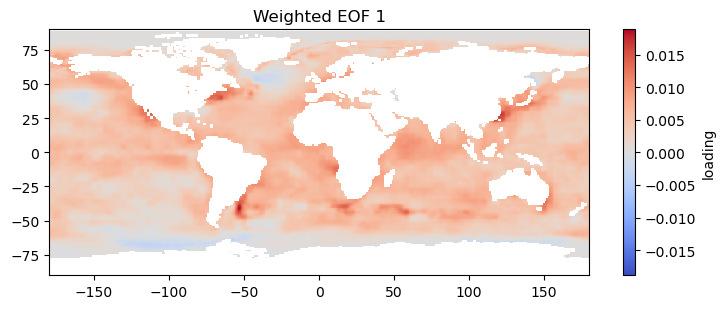

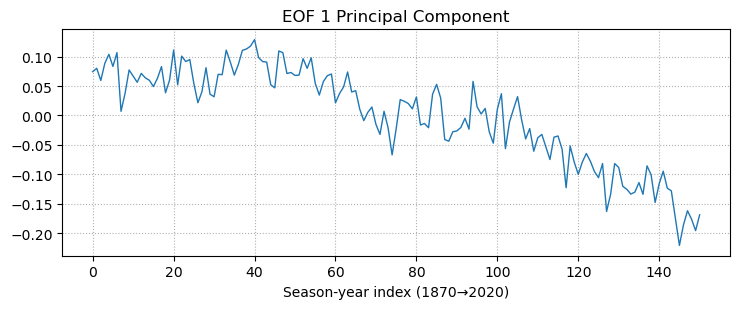

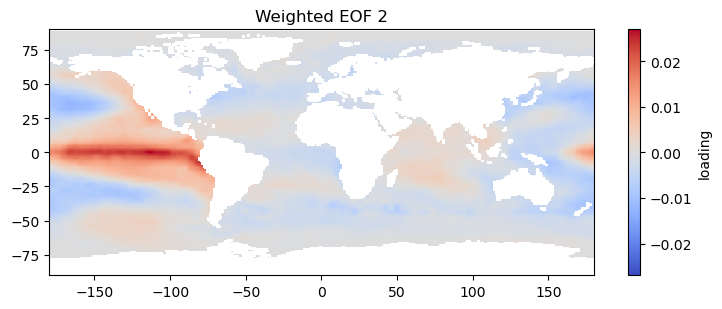

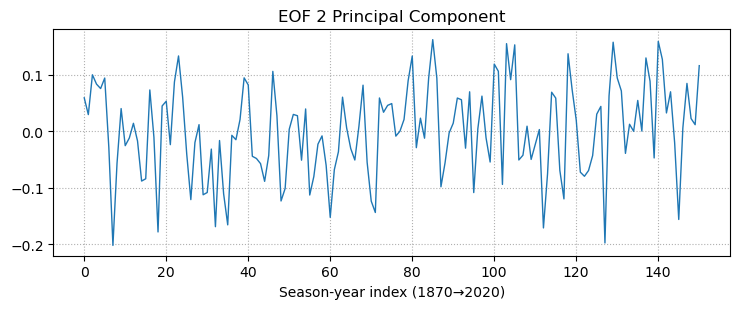

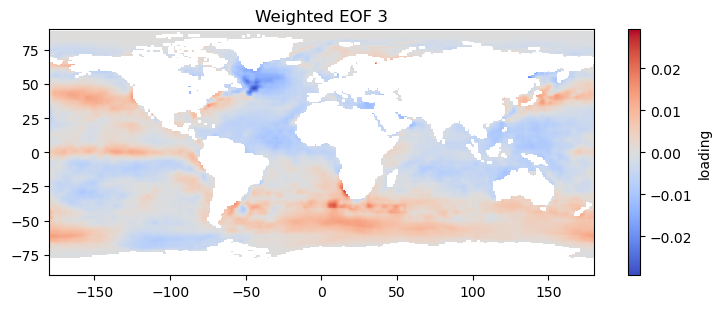

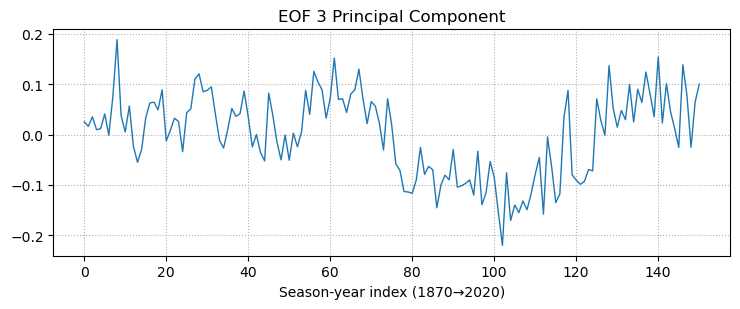

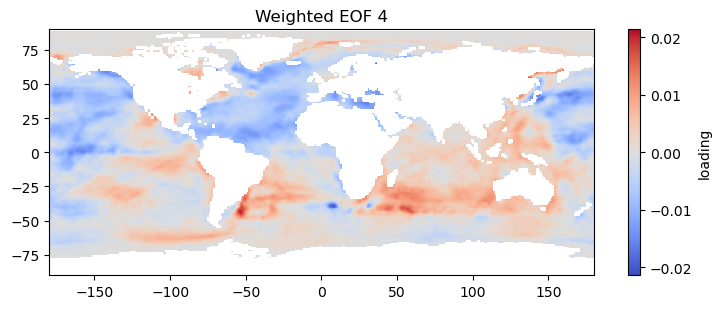

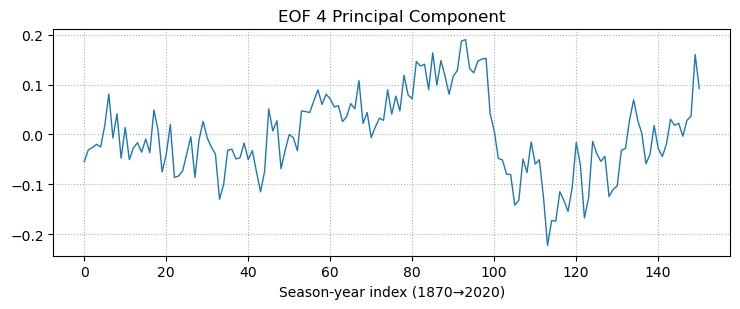

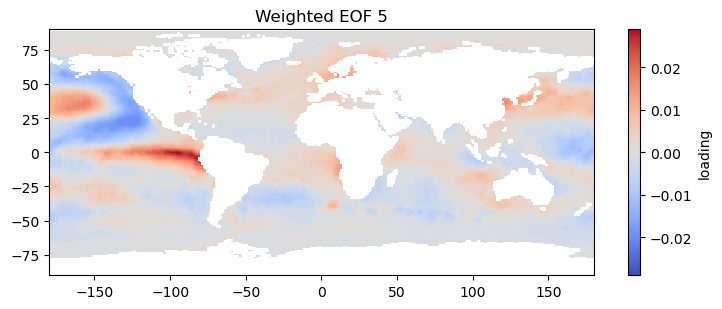

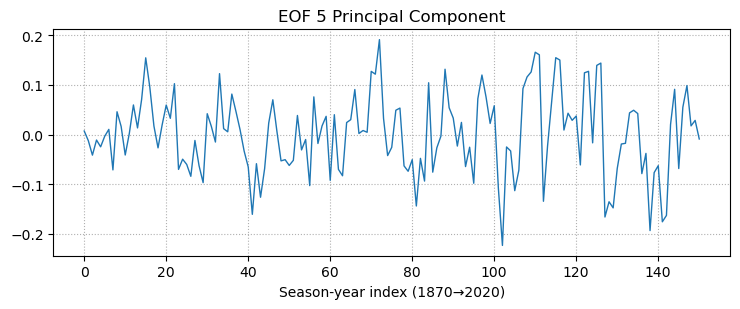

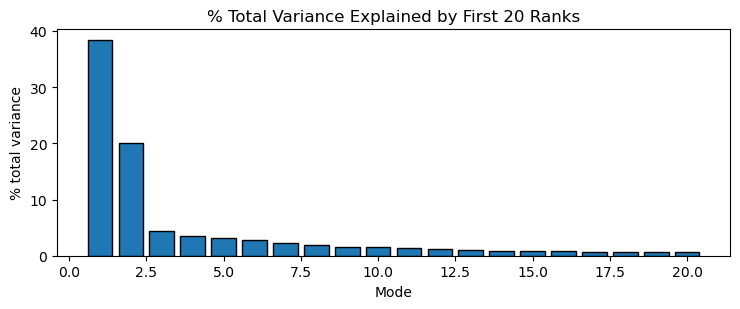

The first 3 terms explain 62.76833724975586 % of total variance. 
 
The first 20 terms explain 88.05057525634766 % of total variance. 
 

=== df_LIG (cores metadata with rounded coords) ===
                  ID  origin_lon  origin_lat  round_lon  round_lat
0      M23323-1_UK37        5.92       67.77        5.5       67.5
1             V28-14      -29.57       64.78      -29.5       64.5
2        EW9302-JPC8      -25.00       61.42      -24.5       61.5
3            ODP 980      -14.70       55.48      -14.5       55.5
4             V27-20      -46.20       54.00      -46.5       54.5
5           M23414-9      -20.29       53.53      -20.5       53.5
6            NEAP18k      -30.35       52.76      -30.5       52.5
7             V23-82      -21.93       52.58      -21.5       52.5
8             K708-1      -23.74       50.00      -23.5       50.5
9          MD04-2845       -5.22       45.35       -5.5       45.5
10           V29-179      -23.51       44.00      -23.5       44.5
11    

In [15]:
# =====================================================================
# Containers for outputs
# =====================================================================
# Spatial/temporal patterns for first 5 modes → plotted below
# Variance explained bar → plotted below
# Full df_LIG printout → printed below
# First 5 time-steps of y′_{t,c} → collected
# Final reconstructions at key ages
T_key_phys = {}         # map age → (N_full,) with NaNs on land
T_all_phys = []         # optional: collect all time slices if desired

# =====================================================================
# STEP 16–24 : Build operators, errors; RSOI; T_t; de-weight; map
# =====================================================================

# Build the fixed H (n_cores × N), then slice to valid rows per t
H_bool = np.zeros((n_cores, N), dtype=bool)
for i, idx in row_lookup.items():
    H_bool[i, idx] = True
H = H_bool.astype(float)

# Variance explained (%)
var_pct = (s**2 / np.sum(s**2)) * 100.0

# === Plots required #1: spatial + temporal patterns for first 5 modes ===
for m in range(5):
    # Fill to full grid for plotting
    spatial_flat = np.full(N_full, np.nan)
    spatial_flat[valid_indices] = E[:, m]          # weighted EOF spatial pattern
    plot_mode_fields(spatial_flat, V[:, m], nlat, nlon, lats, lons, m)

# === Plots required #2: variance explained for first 20 modes ===
fig, ax = plt.subplots(figsize=(7.5, 3.2))
ax.bar(np.arange(1, 21), var_pct[:20], edgecolor="k")
ax.set_title("% Total Variance Explained by First 20 Ranks")
ax.set_xlabel("Mode"); ax.set_ylabel("% total variance")
plt.tight_layout(); plt.show()

# Cumulative percentage of total variance explained by the first 3 and 20 ranks
first_3_var = np.sum(var_pct[:3])
print(f"The first 3 terms explain {first_3_var} % of total variance. \n ")

first_20_var = np.sum(var_pct[:20])
print(f"The first 20 terms explain {first_20_var} % of total variance. \n ")

# === Print required #3: df_LIG (with rounded coords) ===
pd.set_option("display.max_rows", None)
print("\n=== df_LIG (cores metadata with rounded coords) ===")
print(df_LIG[["ID", "origin_lon", "origin_lat", "round_lon", "round_lat"]])

R_t_list = []    # store R_t for each time step
p_t_list = []    # store p_t (RSOI amplitudes) for each time step

# Loop over time slices (as stored: 115 → 130 ascending)
for t in range(151):
    age = ages_asc[t]

    # STEP 16: Selection at time t
    valid_core = (~np.isnan(Y[:, t])) & core_has_row
    if not np.any(valid_core):
        # Collect a placeholder for first y's if within first five times
        if t < 1:
            yprime_c_first.append(pd.DataFrame({"core_idx": [], "ID": [], "age_ka": age, "yprime_c": []}))
        T_all_phys.append(np.full(N_full, np.nan))
        continue

    H_t = H[valid_core, :]                           # (n_t × N)
    core_rows_t = np.where(valid_core)[0]
    grid_rows   = [row_lookup[i] for i in core_rows_t]  # grid row indices in ocean-only array

    # STEP 13: Weighted observations y′ (only the present rows)
    y_t_phys = Y[valid_core, t]                       # (n_t,)
    sqrtw_sel = sqrtw[grid_rows]                      # (n_t,)
    y_prime = sqrtw_sel * y_t_phys                    # (n_t,)

    # STEP 14: Summer correction in weighted space
    summer_sel = summer_mask[valid_core]              # (n_t,)
    if np.any(summer_sel):
        y_prime[summer_sel] = y_prime[summer_sel] - x_Aug_prime[grid_rows][summer_sel]

    # STEP 15: Centralize with weighted mean x′
    y_prime_c = y_prime - x_prime[grid_rows]          # (n_t,)

    # Save first time-steps of y′_{t,c} for print
    if t < 1:
        df_first = pd.DataFrame({
            "core_idx": core_rows_t,
            "ID": df_LIG.ID.values[core_rows_t],
            "age_ka": age,
            "yprime_c": y_prime_c
        })
        yprime_c_first.append(df_first)

    # STEP 16: 𝓗_t = H_t E (n_t × r)
    Hcal = H_t[:, grid_rows] * 0.0   # placeholder not used; we build directly below
    Hcal = np.stack([E[grid_rows, k] for k in range(r)], axis=1)   # (n_t, r)

    # STEP 17–18: Residual-mode covariance and Obs error (weighted)
    # Residual variance diagonal at the observed rows:
    if E_tilde.shape[1] > 0:
        E_tilde_slice = E_tilde[grid_rows, :]                         # (n_t, T-r)
        red_diag = (E_tilde_slice**2) @ lam_tilde_vec                 # (n_t,)
    else:
        red_diag = np.zeros_like(y_prime_c)

    # Observational variance at time t (physical σ), then weight by w_i:
    sigma_t = Sigma[valid_core, t]                                    # (n_t,)
    obs_diag = (sqrtw_sel**2) * (sigma_t**2)                          # = w_i σ_i^2

    # STEP 19: Total error R_t (n_t × n_t) – diagonal in this construction
    R_t = np.diag(red_diag + obs_diag)

    # STEP 20: RSOI (first form) p_t = Λ 𝓗_tᵀ (𝓗_t Λ 𝓗_tᵀ + R_t)^{-1} y′_{t,c}
    # Build M = 𝓗_t Λ 𝓗_tᵀ + R_t
    M = Hcal @ Λ @ Hcal.T + R_t  # (n_t, n_t)

    try:
        # Solve M x = y′ for x, then p_t = Λ 𝓗_tᵀ x
        x_sol = np.linalg.solve(M, y_prime_c)               # (n_t,)
        p_t = Λ @ (Hcal.T @ x_sol)                          # (r,)
    except np.linalg.LinAlgError:
        # If ill-conditioned or singular, we flag by printing and skip this frame
        print(f"[FLAG] (𝓗Λ𝓗ᵀ + R)_t is singular/ill-cond at age={age:.1f} ka; skipping reconstruction.")
        T_all_phys.append(np.full(N_full, np.nan))
        continue

    # STEP 21: Weighted full-field anomaly T_t = E p_t  (N,)
    T_t = E @ p_t
    
    # STEP 21.5: Store full matrix and amplitude as lists for later debugging
    R_t_list.append(R_t.copy())     # store full matrix (diagonal)
    p_t_list.append(p_t.copy())     # store amplitude vector

    # STEP 22: Physical anomalies (de-weight once)
    T_phys = np.zeros(N)
    nonzero = sqrtw > 0
    T_phys[nonzero] = T_t[nonzero] / sqrtw[nonzero]
    T_phys[~nonzero] = np.nan

    # STEP 23: Remap to 180×360 with land as NaN
    field_full = np.full(N_full, np.nan)
    field_full[valid_indices] = T_phys

    # Keep full field
    T_all_phys.append(field_full)

    # STEP 24: Store requested slices (130, 127, 125, 120, 115 ka)
    # ages_asc is ascending; we’ll map exact columns elsewhere for plotting,
    # but here we just collect per-step, so handle after the loop.

## 3. Visualize and animate the full field

**(a)** Reconstructed SST anomaly from 1870-2020 climatological mean

**(b)** Error standard deviation

**(c)** Reconstructed actual SST by adding the 1870-2020 mean to (a)


=== First time-step of y_t (centralized, weighted) ===
    core_idx                ID  age_ka  yprime_c
0          0     M23323-1_UK37   115.0 -0.009020
1          1            V28-14   115.0 -0.005486
2          2       EW9302-JPC8   115.0 -0.006272
3          3           ODP 980   115.0 -0.006081
4          4            V27-20   115.0  0.005315
5          5          M23414-9   115.0 -0.008956
6          6           NEAP18k   115.0 -0.016246
7          7            V23-82   115.0 -0.007611
8          8            K708-1   115.0 -0.003329
9          9         MD04-2845   115.0 -0.005165
10        10           V29-179   115.0 -0.003148
11        11           SU92-03   115.0 -0.011793
12        12             D-117   115.0  0.001649
13        13          CH69-K09   115.0 -0.013398
14        14            V30-97   115.0 -0.009300
15        15    MD95-2040_UK37   115.0  0.001420
16        16           SU90-03   115.0 -0.009103
17        17    MD01-2444_UK37   115.0  0.005648
18        18 

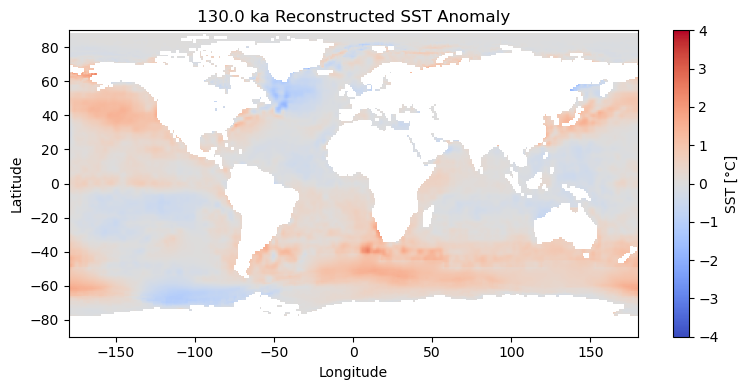

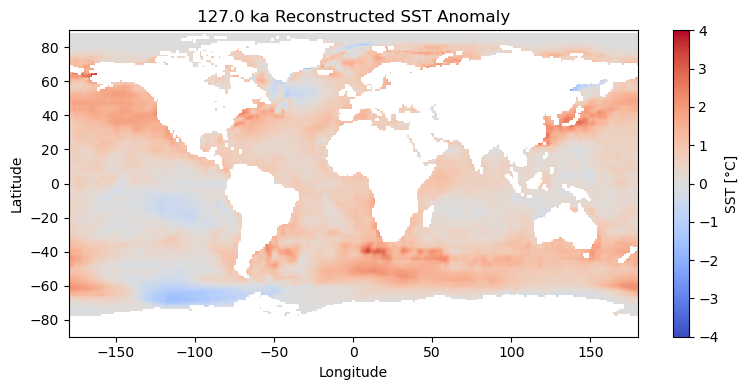

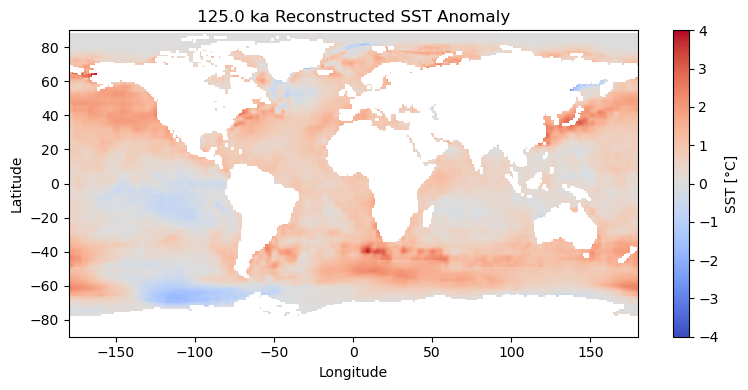

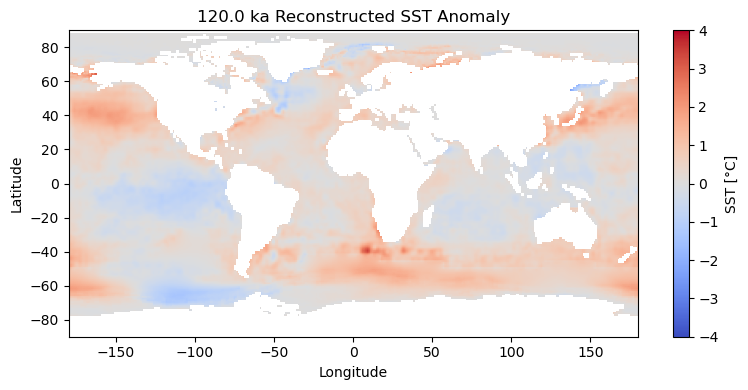

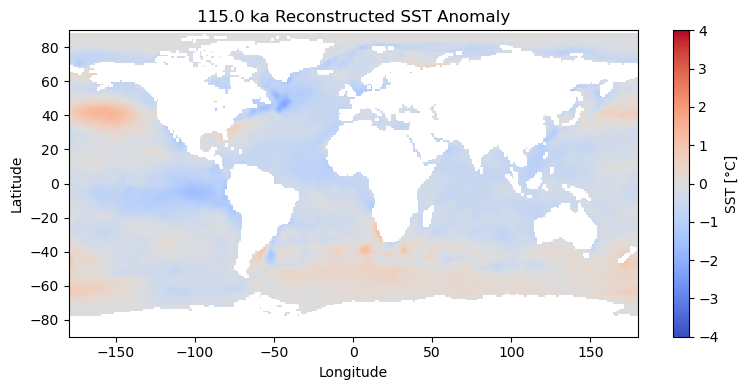

In [16]:
# =====================================================================
# Key timeslices prints/plots
# =====================================================================

# Print required #4: first time-step of centralized, weighted y_t
print("\n=== First time-step of y_t (centralized, weighted) ===")
if len(yprime_c_first) > 0:
    yprime_c_first_df = pd.concat(yprime_c_first, ignore_index=True)
    print(yprime_c_first_df)
else:
    print("(no valid observations found in first five steps)")

# Plot required #5: Final reconstructions at ages 130, 127, 125, 120, 115 Kya
lats_flat = np.repeat(lats[:, None], nlon, axis=1)
lons_flat = np.repeat(lons[None, :], nlat, axis=0)
for age in key_ages:
    # Map age → column index in ascending ages
    idx = nearest_index_age(ages_asc, age)
    if idx < len(T_all_phys):
        field_full = T_all_phys[idx].reshape(nlat, nlon)
        vmax = 4.0
        plt.figure(figsize=(8, 4))
        plt.imshow(field_full, origin='lower', extent=[-180, 180, -90, 90],
                   cmap='coolwarm', vmin=-vmax, vmax=vmax, aspect='auto')
        plt.title(f"{age:.1f} ka Reconstructed SST Anomaly")
        plt.colorbar(label="SST [°C]")
        plt.ylabel('Latitude')
        plt.xlabel('Longitude')
        plt.tight_layout()
        plt.show()
    else:
        print(f"[FLAG] Missing reconstruction for age {age:.1f} ka")

SST Anomaly animation saved → 0131_LIG_Amonaly_SST.gif


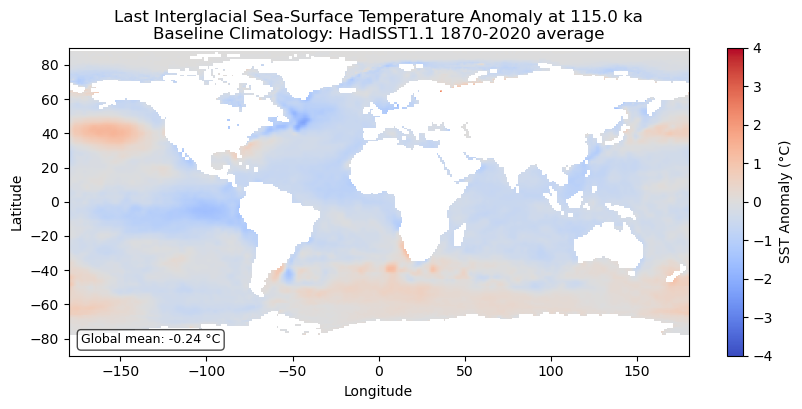

In [17]:
# ─────────────────────────────────────────────────────────────
# Animation: build per-frame rasters from T_all_phys (phys anomalies)
# ─────────────────────────────────────────────────────────────
# Assumes the following already exist from your reconstruction:
#   - T_all_phys : list of length 151; each item is (N_full,) with NaNs on land
#   - nlat, nlon : grid shape
#   - ages_asc   : np.linspace(115.0, 130.0, 151)  (ascending ages)

N_full = nlat * nlon
anomaly_maps = []
mins, maxs = [], []

for t in range(151):
    if t < len(T_all_phys) and T_all_phys[t] is not None:
        flat = T_all_phys[t]
    else:
        flat = np.full(N_full, np.nan)

    field = flat.reshape(nlat, nlon)
    anomaly_maps.append(field)
    if np.isfinite(field).any():
        mins.append(np.nanmin(field))
        maxs.append(np.nanmax(field))

vmin, vmax = -4.0, 4.0

# ─────────────────────────────────────────────────────────────
# Animation 130.0 → 115.0 kya (descending age)
# ─────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 4))
initial_idx = 150  # 130.0 kya (since ages_asc is 115→130 ascending)
im = ax.imshow(
    anomaly_maps[initial_idx],
    origin="lower", extent=[-180, 180, -90, 90],
    cmap="coolwarm", vmin=vmin, vmax=vmax, aspect="auto"
)
cbar = fig.colorbar(im, ax=ax, label="SST Anomaly (°C)")

title = ax.set_title(
    f"Last Interglacial Sea-Surface Temperature Anomaly at {115.0 + 0.1*initial_idx:.1f} ka\n"
    "Baseline Climatology: HadISST1.1 1870-2020 average"
)
xlabel = ax.set_xlabel("Longitude")
ylabel = ax.set_ylabel("Latitude")

gm_text = ax.text(
    0.02, 0.04, "", transform=ax.transAxes,
    fontsize=9, bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
)

def update(frame):
    # Play backward in age: 130.0 → 115.0 kya
    idx = 150 - frame
    age = 115.0 + 0.1 * idx

    im.set_array(anomaly_maps[idx])
    title.set_text(
        f"Last Interglacial Sea-Surface Temperature Anomaly at {age:.1f} ka\n"
        "Baseline Climatology: HadISST1.1 1870-2020 average"
    )
    gm = np.nanmean(anomaly_maps[idx])
    gm_text.set_text(f"Global mean: {gm:+.2f} °C")

    return im, title, gm_text

anim = animation.FuncAnimation(fig, update, frames=151, blit=True)

gif_path = "0131_LIG_Amonaly_SST.gif"
anim.save(gif_path, writer=animation.PillowWriter(fps=20))
print(f"SST Anomaly animation saved → {gif_path}")

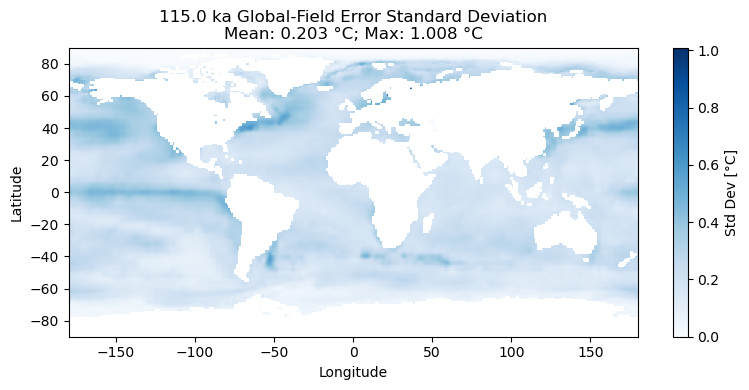

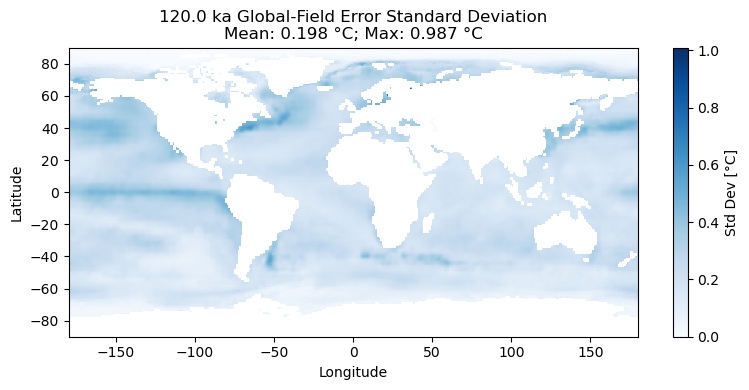

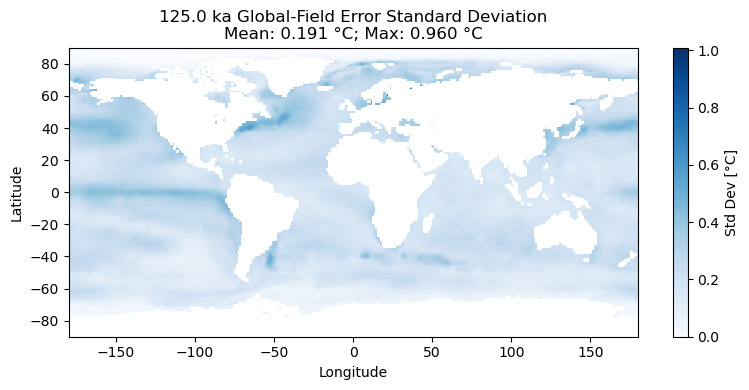

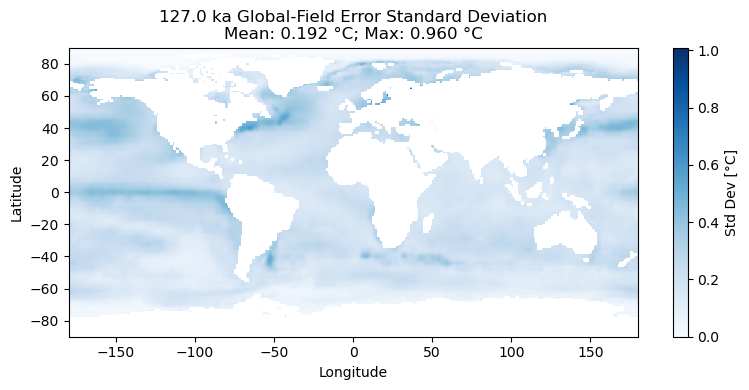

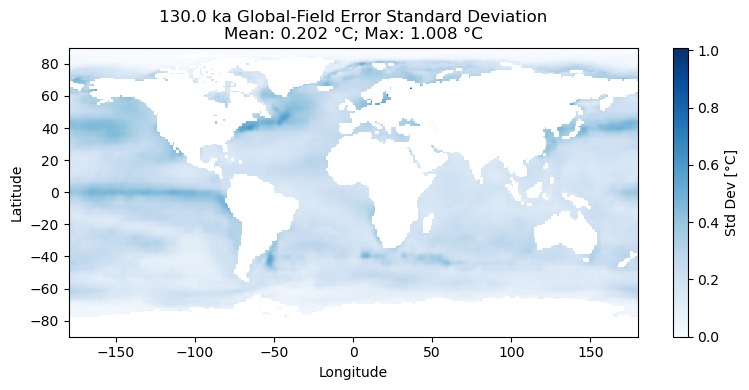

In [18]:
# ────────────────────────────────────────────────────────────────
# Global-field error standard deviation mapping (updated on Jan 31st: now correctly computes posterior error sqrt(diag(P_t)))
# ────────────────────────────────────────────────────────────────
# Compute std(P_t) at ALL ocean grid points for each time step,
# where P_t is the posterior covariance of the field.
# This differs from the previous version which approximated with R_t.

def rt_std_phys_for_time(t, std_phys_all, row_lookup, Y):
    """
    Get site-wise physical std dev from the global posterior std at time t.
    Returns (site_idx, std_phys, grid_rows) where std_phys is in °C.
    """
    n_sites = Y.shape[0]
    valid_site = ~np.isnan(Y[:, t])  # sites that contribute at this time
    if not np.any(valid_site):
        return np.array([], dtype=int), np.array([]), np.array([], dtype=int)

    site_idx  = np.where(valid_site)[0]
    grid_rows = np.array([row_lookup[i] for i in site_idx], dtype=int)

    std_phys = std_phys_all[grid_rows]

    return site_idx, std_phys, grid_rows

# Compute posterior error std for all times
error_std_global_all = []
reduced_space_error_P_t_OI = []
for t in range(151):
    age = ages_asc[t]

    # STEP 16: Selection at time t (same as in reconstruction loop)
    valid_core = (~np.isnan(Y[:, t])) & core_has_row
    if not np.any(valid_core):
        error_std_global_all.append(np.full(N, np.nan))
        continue

    core_rows_t = np.where(valid_core)[0]
    grid_rows = [row_lookup[i] for i in core_rows_t]

    # STEP 13-15: Weighted, corrected, centralized observations (same as reconstruction)
    y_t_phys = Y[valid_core, t]
    sqrtw_sel = sqrtw[grid_rows]
    y_prime = sqrtw_sel * y_t_phys
    summer_sel = summer_mask[valid_core]
    if np.any(summer_sel):
        y_prime[summer_sel] = y_prime[summer_sel] - x_Aug_prime[grid_rows][summer_sel]
    y_prime_c = y_prime - x_prime[grid_rows]

    # STEP 16: Hcal = H_t E (n_t × r)
    Hcal = np.stack([E[grid_rows, k] for k in range(r)], axis=1)

    # STEP 17-19: Error covariances (same as reconstruction)
    if E_tilde.shape[1] > 0:
        E_tilde_slice = E_tilde[grid_rows, :]
        red_diag = (E_tilde_slice**2) @ lam_tilde_vec
    else:
        red_diag = np.zeros_like(y_prime_c)
    sigma_t = Sigma[valid_core, t]
    obs_diag = (sqrtw_sel**2) * (sigma_t**2)
    R_t = np.diag(red_diag + obs_diag)

    # STEP 20: M = Hcal Λ Hcal^T + R_t
    M = Hcal @ Λ @ Hcal.T + R_t

    try:
        M_inv = np.linalg.inv(M)
    except np.linalg.LinAlgError:
        #error_std_global_all.append(np.full(N, np.nan))
        print("lin alg error: M = Hcal Λ Hcal^T + R_t is not invertible.")
        break

    # Posterior covariance for amplitudes: \mathcal{P}_t^{\text{OI}} = \Lambda - \Lambda \mathcal{H}^\intercal_t (\mathcal{H}_t \Lambda \mathcal{H}_t^\intercal + \mathbf{R}_t)^{-1} \mathcal{H}_t\Lambda
    P_t = Λ - Λ @ Hcal.T @ M_inv @ Hcal @ Λ

    # Field posterior covariance: \mathbf{P}_t = \mathbf{E} \mathcal{P}_t^{\text{OI}} \mathbf{E}^\intercal
    # Diagonal: \sqrt{\text{diag}(\mathbf{P}_t)}
    T_error_cov_diag = np.sum(E * (P_t @ E.T).T, axis=1)
    std_weighted = np.sqrt(T_error_cov_diag)

    # Physical std
    std_phys_all = std_weighted / sqrtw

    # Append the computed results: \mathcal{p]^{OI} in the reduced space, and the \mathbf{P}_t in the full-space
    reduced_space_error_P_t_OI.append(P_t)
    error_std_global_all.append(std_phys_all)

# Find global max std across all times for consistent colorbar scaling
global_std_max = np.nanmax([np.nanmax(s) for s in error_std_global_all if np.isfinite(s).any()])

# Plot static uncertainty maps at selected ages
ages_to_plot = [115.0, 120.0, 125.0, 127.0, 130.0]

for age in ages_to_plot:
    idx = nearest_index_age(ages_asc, age)
    
    # Get global-field std (N,) and reshape to (nlat, nlon)
    std_ocean = error_std_global_all[idx]
    
    # Remap to full grid with NaN on land
    std_full = np.full(N_full, np.nan)
    std_full[valid_indices] = std_ocean
    std_field = std_full.reshape(nlat, nlon)
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 4))
    im = ax.imshow(
        std_field,
        origin='lower',
        extent=[-180, 180, -90, 90],
        cmap='Blues',
        vmin=0,
        vmax=global_std_max,
        aspect='auto'
    )
    cbar = fig.colorbar(im, ax=ax, label='Std Dev [°C]')
    
    # Compute and display mean and max std dev
    mean_std = np.nanmean(std_ocean)
    max_std = np.nanmax(std_ocean)
    ax.set_title(f'{age:.1f} ka Global-Field Error Standard Deviation\nMean: {mean_std:.3f} °C; Max: {max_std:.3f} °C')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    
    plt.tight_layout()
    plt.show()

Error std animation saved → 0131_LIG_Error_Std_Animation.gif


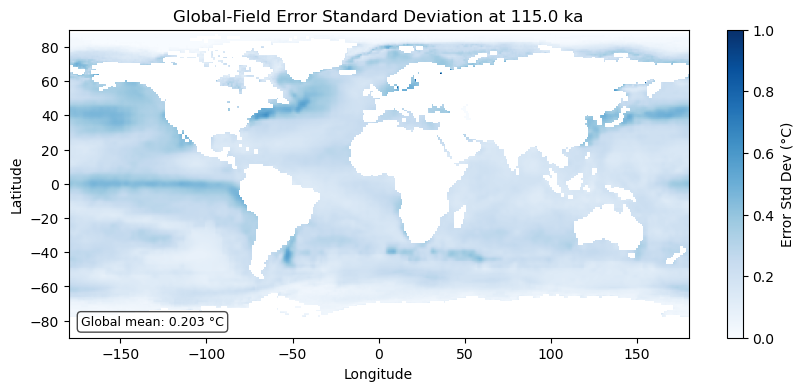

In [19]:
# ------------------------------------------------------------
# Animation for global-field error standard deviation
# ------------------------------------------------------------

# Build per-frame rasters from error_std_global_all (error std)
# Assumes error_std_global_all already exists from previous cell

error_maps = []
for t in range(151):
    if t < len(error_std_global_all) and error_std_global_all[t] is not None:
        flat = error_std_global_all[t]
    else:
        flat = np.full(N, np.nan)

    # Remap to full grid with NaN on land
    std_full = np.full(N_full, np.nan)
    std_full[valid_indices] = flat
    field = std_full.reshape(nlat, nlon)
    error_maps.append(field)

vmin, vmax = 0, 1

# Animation 130.0 → 115.0 kya (descending age)
fig, ax = plt.subplots(figsize=(10, 4))
initial_idx = 150  # 130.0 kya
im = ax.imshow(
    error_maps[initial_idx],
    origin="lower", extent=[-180, 180, -90, 90],
    cmap="Blues", vmin=vmin, vmax=vmax, aspect="auto"
)
cbar = fig.colorbar(im, ax=ax, label="Error Std Dev (°C)")

title = ax.set_title(
    f"Global-Field Error Standard Deviation at {115.0 + 0.1*initial_idx:.1f} ka"
)
xlabel = ax.set_xlabel(
    "Longitude"
)
ylabel = ax.set_ylabel(
    "Latitude"
)

gm_text = ax.text(
    0.02, 0.04, "", transform=ax.transAxes,
    fontsize=9, bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
)

def update(frame):
    # Play backward in age: 130.0 → 115.0 kya
    idx = 150 - frame
    age = 115.0 + 0.1 * idx

    im.set_array(error_maps[idx])
    title.set_text(
        f"Global-Field Error Standard Deviation at {age:.1f} ka"
    )
    gm = np.nanmean(error_maps[idx])
    gm_text.set_text(f"Global mean: {gm:.3f} °C")

    return im, title, gm_text

anim = animation.FuncAnimation(fig, update, frames=151, blit=True)

gif_path = "0131_LIG_Error_Std_Animation.gif"
anim.save(gif_path, writer=animation.PillowWriter(fps=20))
print(f"Error std animation saved → {gif_path}")

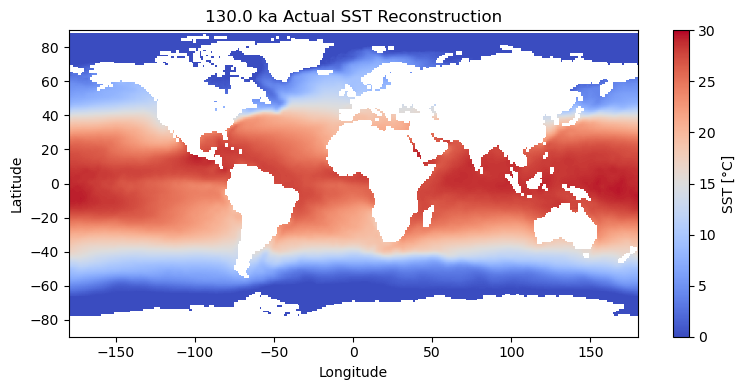

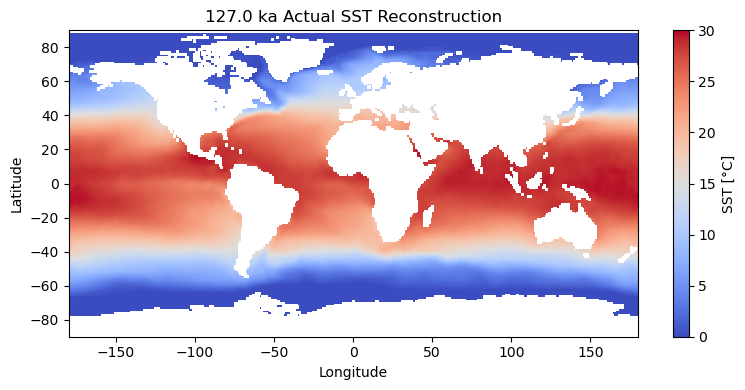

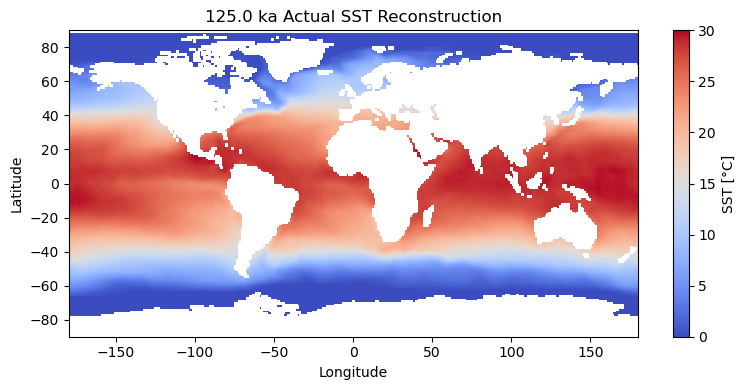

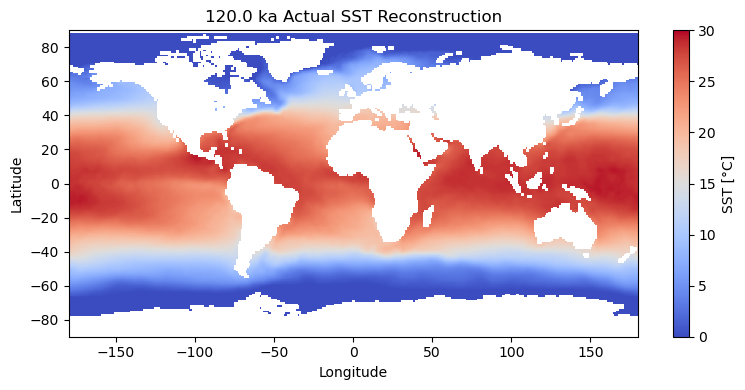

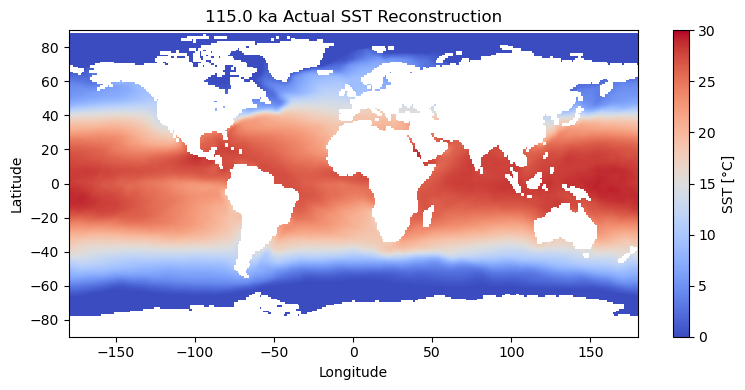

In [20]:
# ─────────────────────────────────────────────────────────────
# Compute and visualize actual SST (not anomaly) by adding back the 1870-2020 climatological mean
# ─────────────────────────────────────────────────────────────

# Climatological mean in physical space (ocean-only, N elements)
x_clim = x[:, 0]  # (N,) - mean SST over 1870-2020 at each ocean grid point

# Map to full grid (N_full,) with NaNs on land
x_clim_full = np.full(N_full, np.nan)
x_clim_full[valid_indices] = x_clim

# Compute actual SST for all time slices: anomaly + climatology
SST_actual_all = [T_all_phys[t] + x_clim_full for t in range(len(T_all_phys))]

# ─────────────────────────────────────────────────────────────
# Plot actual SST at key ages (130, 127, 125, 120, 115 ka)
# ─────────────────────────────────────────────────────────────
for age in key_ages:
    idx = nearest_index_age(ages_asc, age)
    if idx < len(SST_actual_all):
        sst_field = SST_actual_all[idx].reshape(nlat, nlon)
        vmax = 30.0  # Typical SST range
        vmin = 0.0
        plt.figure(figsize=(8, 4))
        plt.imshow(sst_field, origin='lower', extent=[-180, 180, -90, 90],
                   cmap='coolwarm', vmin=vmin, vmax=vmax, aspect='auto')
        plt.title(f"{age:.1f} ka Actual SST Reconstruction")
        plt.colorbar(label="SST [°C]")
        plt.ylabel('Latitude')
        plt.xlabel('Longitude')
        plt.tight_layout()
        plt.show()
    else:
        print(f"[FLAG] Missing reconstruction for age {age:.1f} ka")

Climatology restored full-field SST animation saved → 0131_LIG_Climatology_Restored_SST.gif


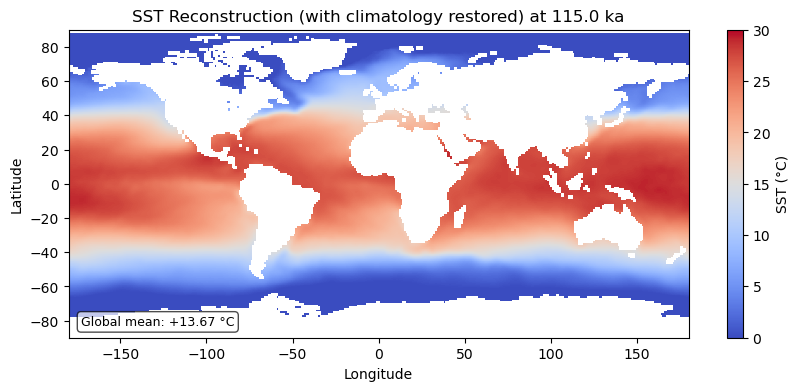

In [21]:
# ─────────────────────────────────────────────────────────────
# Animation of climatology-restored SST: 130.0 → 115.0 kya
# ─────────────────────────────────────────────────────────────

# Build per-frame rasters from SST_actual_all 
# the physical-state SST by adding anomaly + mean
actual_maps = []
for t in range(len(SST_actual_all)):
    if SST_actual_all[t] is not None:
        field = SST_actual_all[t].reshape(nlat, nlon)
        actual_maps.append(field)

vmin, vmax = 0.0, 30.0

fig, ax = plt.subplots(figsize=(10, 4))
initial_idx = 150  # 130.0 kya
im = ax.imshow(
    actual_maps[initial_idx],
    origin="lower", extent=[-180, 180, -90, 90],
    cmap="coolwarm", vmin=vmin, vmax=vmax, aspect="auto"
)
cbar = fig.colorbar(im, ax=ax, label="SST (°C)")

title = ax.set_title(
    f"SST Reconstruction (with climatology restored) at {115.0 + 0.1*initial_idx:.1f} ka"
)
xlabel = ax.set_xlabel("Longitude")
ylabel = ax.set_ylabel("Latitude")
gm_text = ax.text(
    0.02, 0.04, "", transform=ax.transAxes,
    fontsize=9, bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
)

def update(frame):
    idx = 150 - frame
    age = 115.0 + 0.1 * idx

    im.set_array(actual_maps[idx])
    title.set_text(f"SST Reconstruction (with climatology restored) at {age:.1f} ka")
    gm = np.nanmean(actual_maps[idx])
    gm_text.set_text(f"Global mean: {gm:+.2f} °C")

    return im, title, gm_text

anim = animation.FuncAnimation(fig, update, frames=151, blit=True)

gif_path = "0131_LIG_Climatology_Restored_SST.gif"
anim.save(gif_path, writer=animation.PillowWriter(fps=20))
print(f"Climatology restored full-field SST animation saved → {gif_path}")

## 4. Regional area-weighed analysis

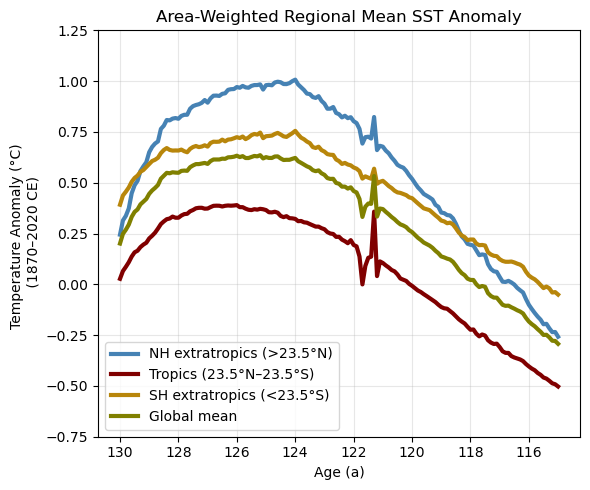

In [22]:
# ------------------------------------------------------------
# Regional Mean by Latitude Band using area-weighted T_t
# ------------------------------------------------------------

# Time axis (ascending 115 → 130)
years = ages_asc.copy()

# Latitude grids & masks (full grid)
lat_vals   = lats                      # shape (nlat,)
lat_grid   = np.repeat(lat_vals[:, None], nlon, axis=1)   # 180×360

nh_mask_full   =  lat_grid >  23.5
trop_mask_full = (lat_grid >= -23.5) & (lat_grid <= 23.5)
sh_mask_full   =  lat_grid < -23.5
all_ocean_full = np.full((nlat, nlon), False)
all_ocean_full.flat[valid_indices] = True               # True on ocean cells

# Convert full-grid masks → ocean-only index positions (0..N-1)
nh_pos   = np.where(nh_mask_full.reshape(-1)[valid_indices])[0]
trop_pos = np.where(trop_mask_full.reshape(-1)[valid_indices])[0]
sh_pos   = np.where(sh_mask_full.reshape(-1)[valid_indices])[0]
all_pos  = np.arange(len(valid_indices))

# Precompute denominators (sum w over band) once
nh_denom   = np.nansum(w[nh_pos])
trop_denom = np.nansum(w[trop_pos])
sh_denom   = np.nansum(w[sh_pos])
all_denom  = np.nansum(w[all_pos])

nh_series, trop_series, sh_series, global_series = [], [], [], []

for t in range(151):
    # ocean-only physical anomalies for this time (length N)
    ocean_phys = T_all_phys[t][valid_indices]  # (N,)
    # weighted-space vector T_t = sqrtw * T_phys
    T_t_ocean = sqrtw * ocean_phys

    # numerators: sum( sqrtw * T_t ) over band == sum( w * T_phys ) over band
    nh_num   = np.nansum( np.sqrt(w[nh_pos])   * T_t_ocean[nh_pos] )
    trop_num = np.nansum( np.sqrt(w[trop_pos]) * T_t_ocean[trop_pos] )
    sh_num   = np.nansum( np.sqrt(w[sh_pos])   * T_t_ocean[sh_pos] )
    all_num  = np.nansum( np.sqrt(w[all_pos])  * T_t_ocean[all_pos] )

    # band means in °C (physical)
    nh_series.  append(nh_num   / nh_denom if nh_denom   > 0 else np.nan)
    trop_series.append(trop_num / trop_denom if trop_denom > 0 else np.nan)
    sh_series.  append(sh_num   / sh_denom if sh_denom   > 0 else np.nan)
    global_series.append(all_num / all_denom if all_denom > 0 else np.nan)

nh_series   = np.array(nh_series)
trop_series = np.array(trop_series)
sh_series   = np.array(sh_series)
global_series = np.array(global_series)

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
plt.figure(figsize=(6, 5))
plt.plot(years, nh_series,     color='steelblue',      linewidth=3, label='NH extratropics (>23.5°N)')
plt.plot(years, trop_series,   color='maroon',         linewidth=3, label='Tropics (23.5°N–23.5°S)')
plt.plot(years, sh_series,     color='darkgoldenrod',  linewidth=3, label='SH extratropics (<23.5°S)')
plt.plot(years, global_series, color='olive',          linewidth=3, label='Global mean')

plt.gca().invert_xaxis()  # show 130 → 115 left to right
plt.title('Area-Weighted Regional Mean SST Anomaly')
plt.xlabel('Age (a)');  plt.ylabel('Temperature Anomaly (°C) \n (1870–2020 CE)')
plt.grid(alpha=0.3)
plt.legend(loc='lower left')
plt.ylim(-0.75, 1.25)
plt.tight_layout()
plt.show()

## 5. Save results as NetCDF / csv files

In [48]:
# Save reconstructed SST and error standard deviation as NetCDF files

import xarray as xr

# Prepare SST data: stack T_all_phys into (151, nlat, nlon) with NaNs on land
sst_data = np.stack(T_all_phys, axis=0).reshape(151, nlat, nlon)

# 1. Create xarray Dataset for SST
ds_sst = xr.Dataset({
    'sst_anomaly': (['time', 'latitude', 'longitude'], sst_data)
}, coords={
    'time': ages_asc,
    'latitude': lats,
    'longitude': lons
})

# Save SST NetCDF
ds_sst.to_netcdf('LIG_SST_Anomaly.nc')
print("Saved SST reconstruction to LIG_SST_Anomaly.nc")

# 2.1 Save reduced-space error std as NetCDF

# Stack the list of (r x r) matrices into (151, r, r)
reduced_error_all = np.stack(reduced_space_error_P_t_OI, axis=0)  # (151, r, r)

ds_reduced_error = xr.Dataset({
    'reduced_space_error': (['time', 'mode1', 'mode2'], reduced_error_all)
}, coords={
    'time': ages_asc,
    'mode1': np.arange(r),
    'mode2': np.arange(r)
})

ds_reduced_error.to_netcdf('LIG_Reduced_Space_Error_Std.nc')
print("Saved reduced-space error standard deviationto LIG_Reduced_Space_Error_Std.nc")


# 2.2 Prepare full-field error std data: map error_std_global_all to full grid
error_data = np.full((151, N_full), np.nan)
for t in range(151):
    error_data[t, valid_indices] = error_std_global_all[t]
error_data = error_data.reshape(151, nlat, nlon)

# Create xarray Dataset for full-field error
ds_error = xr.Dataset({
    'full_error_std': (['time', 'latitude', 'longitude'], error_data)
}, coords={
    'time': ages_asc,
    'latitude': lats,
    'longitude': lons
})

# Save error NetCDF
ds_error.to_netcdf('LIG_Full_Field_Error_Std.nc')
print("Saved full-field error standard deviation to LIG_Full_Field_Error_Std.nc")

# 3. Save reduced-space coefficients (p_t) as NetCDF
p_all = np.stack(p_t_list, axis=0)  # (151, r)
ds_p = xr.Dataset({
    'rs_coefficients': (['time', 'mode'], p_all)
}, coords={
    'time': ages_asc,
    'mode': np.arange(r)
})
ds_p.to_netcdf('LIG_RSOI_Coefficients.nc')
print("Saved RSOI coefficients to LIG_RSOI_Coefficients.nc")

# 4. Save all EOFs as NetCDF (all 151 modes)
# Eprime is (N, T), fill to full grid (T, N_full) with NaNs on land
eof_full_data = np.full((T, N_full), np.nan)
for k in range(T):
    eof_full_data[k, valid_indices] = Eprime[:, k]
eof_full_data = eof_full_data.reshape(T, nlat, nlon)

ds_eof_full = xr.Dataset({
    'EOFs_full': (['EOF', 'latitude', 'longitude'], eof_full_data)
}, coords={
    'EOF': np.arange(T),
    'latitude': lats,
    'longitude': lons
})

ds_eof_full.to_netcdf('LIG_EOFs_Full.nc')
print("Saved all EOFs (151) to LIG_EOFs_Full.nc")

# 5. Save all eigenvalues as vector (151,)
eigenvalues_full = (s ** 2) / (T - 1)  # full unbiased eigenvalues

ds_eigenvalues_full = xr.Dataset({
    'eigenvalues_full': (['mode'], eigenvalues_full)
}, coords={
    'mode': np.arange(T)
})

ds_eigenvalues_full.to_netcdf('LIG_Eigenvalues_Full.nc')
print("Saved all eigenvalues (151) to LIG_Eigenvalues_Full.nc")

# 6. Save the climatology-restored physical-state SST as NetCDF

# Stack climatology-restored SST into (151, nlat, nlon)
actual_sst_data = np.stack(SST_actual_all, axis=0).reshape(151, nlat, nlon)

# Create xarray Dataset
ds_actual_sst = xr.Dataset({
    'restored_sst': (['time', 'latitude', 'longitude'], actual_sst_data)
}, coords={
    'time': ages_asc,
    'latitude': lats,
    'longitude': lons
})

# Save NetCDF
ds_actual_sst.to_netcdf('LIG_Climatology_Restored_SST.nc')
print("Saved actual SST reconstruction to LIG_Climatology_Restored_SST.nc")

# ======================================================
# ALSO save the same data as CSV files
# ======================================================
ds_sst.to_dataframe().to_csv('LIG_SST_Anomaly.csv')
print("Saved SST reconstruction to LIG_SST_Anomaly.csv")

ds_reduced_error.to_dataframe().to_csv('LIG_Reduced_Space_Error_Std.csv')
print("Saved reduced-space error standard deviation to LIG_Reduced_Space_Error_Std.csv")

ds_error.to_dataframe().to_csv('LIG_Full_Field_Error_Std.csv')
print("Saved full-field error standard deviation to LIG_Full_Field_Error_Std.csv")

ds_p.to_dataframe().to_csv('LIG_RSOI_Coefficients.csv')
print("Saved RSOI coefficients to LIG_RSOI_Coefficients.csv")

ds_eof_full.to_dataframe().to_csv('LIG_EOFs_Full.csv')
print("Saved all EOFs (151) to LIG_EOFs_Full.csv")

ds_eigenvalues_full.to_dataframe().to_csv('LIG_Eigenvalues_Full.csv')
print("Saved all eigenvalues (151) to LIG_Eigenvalues_Full.csv")

ds_actual_sst.to_dataframe().to_csv('LIG_Climatology_Restored_SST.csv')
print("Saved actual SST reconstruction to LIG_Climatology_Restored_SST.csv")

Saved SST reconstruction to LIG_SST_Anomaly.nc
Saved reduced-space error standard deviationto LIG_Reduced_Space_Error_Std.nc
Saved full-field error standard deviation to LIG_Full_Field_Error_Std.nc
Saved RSOI coefficients to LIG_RSOI_Coefficients.nc
Saved all EOFs (151) to LIG_EOFs_Full.nc
Saved all eigenvalues (151) to LIG_Eigenvalues_Full.nc
Saved actual SST reconstruction to LIG_Climatology_Restored_SST.nc
Saved SST reconstruction to LIG_SST_Anomaly.csv
Saved reduced-space error standard deviation to LIG_Reduced_Space_Error_Std.csv
Saved full-field error standard deviation to LIG_Full_Field_Error_Std.csv
Saved RSOI coefficients to LIG_RSOI_Coefficients.csv
Saved all EOFs (151) to LIG_EOFs_Full.csv
Saved all eigenvalues (151) to LIG_Eigenvalues_Full.csv
Saved actual SST reconstruction to LIG_Climatology_Restored_SST.csv


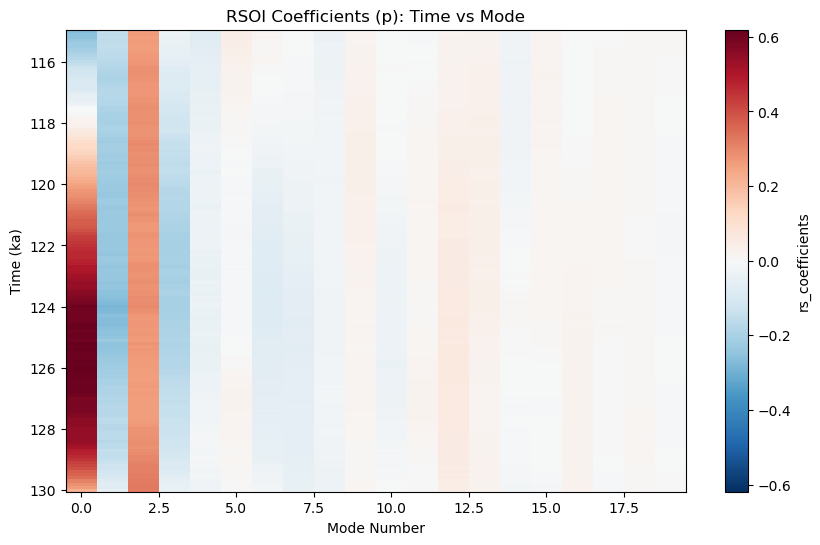

In [37]:
# Plot the RSOI coefficients from NetCDF
ds_p = xr.open_dataset('LIG_RSOI_Coefficients.nc')
ds_p.rs_coefficients.plot(cmap='RdBu_r', figsize=(10, 6))
plt.title('RSOI Coefficients (p): Time vs Mode')
plt.xlabel('Mode Number')
plt.ylabel('Time (ka)')
plt.gca().invert_yaxis()  # since time increases downward in plots
plt.show()

In [ ]:
# ======================================================
# Save all used SST and +/- 2SD data as .csv files across all cores
# ======================================================

# Get list of valid sheets
xls = pd.ExcelFile(excel_file)
valid_sheets = [sheet for sheet in xls.sheet_names if sheet not in non_sst]

# Age array: 115000 to 130000 in steps of 100 (151 values)
ages = np.arange(115000, 130100, 100)

# First CSV: SST (column T)
df_sst = pd.DataFrame({'Age [yr]': ages})
for sheet in valid_sheets:
    data = pd.read_excel(excel_file, sheet_name=sheet, usecols='T', skiprows=1, header=None, nrows=151).values.flatten()
    if len(data) < 151:
        data = np.concatenate([data, np.full(151 - len(data), np.nan)])
    df_sst[sheet] = data
df_sst.to_csv('Hoffman_SST.csv', index=False)
print('Saved SST data to Hoffman_SST.csv')

# Second CSV: SST_minus_2SD (column S)
df_minus_2sd = pd.DataFrame({'Age [yr]': ages})
for sheet in valid_sheets:
    data = pd.read_excel(excel_file, sheet_name=sheet, usecols='S', skiprows=1, header=None, nrows=151).values.flatten()
    if len(data) < 151:
        data = np.concatenate([data, np.full(151 - len(data), np.nan)])
    df_minus_2sd[sheet] = data
df_minus_2sd.to_csv('Hoffman_SST_minus_2SD.csv', index=False)
print('Saved SST_minus_2SD data to Hoffman_SST_minus_2SD.csv')

# Third CSV: SST_plus_2SD (column U)
df_plus_2sd = pd.DataFrame({'Age [yr]': ages})
for sheet in valid_sheets:
    data = pd.read_excel(excel_file, sheet_name=sheet, usecols='U', skiprows=1, header=None, nrows=151).values.flatten()
    if len(data) < 151:
        data = np.concatenate([data, np.full(151 - len(data), np.nan)])
    df_plus_2sd[sheet] = data
df_plus_2sd.to_csv('Hoffman_SST_plus_2SD.csv', index=False)
print('Saved SST_plus_2SD data to Hoffman_SST_plus_2SD.csv')

/var/folders/z1/qxyx9p114qn5g8pjhv3f78j40000gn/T/ipykernel_27411/2671883193.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sst[sheet] = data
/var/folders/z1/qxyx9p114qn5g8pjhv3f78j40000gn/T/ipykernel_27411/2671883193.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_sst[sheet] = data
/var/folders/z1/qxyx9p114qn5g8pjhv3f78j40000gn/T/ipykernel_27411/2671883193.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

Saved SST data to Hoffman_SST.csv


/var/folders/z1/qxyx9p114qn5g8pjhv3f78j40000gn/T/ipykernel_27411/2671883193.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_minus_2sd[sheet] = data
/var/folders/z1/qxyx9p114qn5g8pjhv3f78j40000gn/T/ipykernel_27411/2671883193.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_minus_2sd[sheet] = data
/var/folders/z1/qxyx9p114qn5g8pjhv3f78j40000gn/T/ipykernel_27411/2671883193.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfor

Saved SST_minus_2SD data to Hoffman_SST_minus_2SD.csv


/var/folders/z1/qxyx9p114qn5g8pjhv3f78j40000gn/T/ipykernel_27411/2671883193.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_plus_2sd[sheet] = data
/var/folders/z1/qxyx9p114qn5g8pjhv3f78j40000gn/T/ipykernel_27411/2671883193.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_plus_2sd[sheet] = data
/var/folders/z1/qxyx9p114qn5g8pjhv3f78j40000gn/T/ipykernel_27411/2671883193.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

Saved SST_plus_2SD data to Hoffman_SST_plus_2SD.csv


/var/folders/z1/qxyx9p114qn5g8pjhv3f78j40000gn/T/ipykernel_27411/2671883193.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_plus_2sd[sheet] = data


In [ ]:
# Fourth CSV: Proxy-Core metadata (sheet names, lon, lat)
df_metadata = pd.DataFrame({'Sheet Name': valid_sheets})
lons = []
lats = []
for sheet in valid_sheets:
    meta = pd.read_excel(excel_file, sheet_name=sheet, usecols="B:C", nrows=2, header=None)
    lon = meta.iloc[1, 0]  # B2
    lat = meta.iloc[1, 1]  # C2
    lons.append(lon)
    lats.append(lat)
df_metadata['Longitude'] = lons
df_metadata['Latitude'] = lats
df_metadata.to_csv('Hoffman_Metadata.csv', index=False)
print('Saved core metadata to Hoffman_Metadata.csv')

Saved core metadata to Hoffman_Core_Metadata.csv
